<a href="https://colab.research.google.com/github/Vite-Noiz/Machine-Learning-Course/blob/main/Ensemble%20Learning/Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://github.com/meanxai/

# Random Forest

## DT

In [ ]:
import numpy as np
from collections import Counter
import copy

# Implement a simplified Random Forest using binary tree.
class MyDTreeClassifierRF:
    def __init__(self, max_depth, max_samples, max_features):
        self.max_depth = max_depth
        self.max_samples = max_samples
        self.max_features = max_features
        self.u_class = None      # unique class (target y value)
        self.estimator1 = dict() # tree result-1: each leaf contains the data index.
        self.estimator2 = dict() # tree result-2: each leaf contains the majority class.
        self.feature = None      # feature value. will be x_train when fit() is called.
        self.target = None       # target value. will be y_train when fit() is called.
        self.iob_pred = None     # predicted classes of train data points
        self.oob_pred = None     # predicted classes of OOB data points

    # Calculate Gini index of a leaf node
    def gini_index(self, leaf):
        n = leaf.shape[0]

        if n > 1:
            gini = 1.0
            for c in self.u_class:
                cnt = (self.target[leaf] == c).sum()
                gini -= (cnt / n) ** 2
            return gini
        else:
            return 0.0

    # split a node into left and right.
    # Find the best split point with highest information gain, and split node with it.
    # did: data index on the leaf node.
    def node_split(self, did):
        n = did.shape[0]

        # Gini index of parent node before splitting.
        p_gini = self.gini_index(did)

        # perform column subsampling without replacement
        m = self.max_features
        p = self.feature.shape[1]
        f_list = np.random.choice(np.arange(0, p), m, replace=False)

        # Split the node into all candidates for all features and find
        # the best feature and the best split point with the highest
        # information gain.
        # fid: feature_id
        max_ig = -999999
        for fid in f_list:
            # feature data to be split
            x_feat = self.feature[did, fid].copy()

            # split x_feat using the best feature and the best split point.
            # Note: The code below is inefficient because it sorts x_feat
            #       every time it is split. Future improvements are needed.

            # remove duplicates of x_feat and sort in ascending order
            x_uniq = np.unique(x_feat)

            # list up all the candidates, which are the midpoints of adjacent data points.
            s_point = [np.mean([x_uniq[i-1], x_uniq[i]]) for i in range(1, len(x_uniq))]

            # len(s_point) > 1: Calculate the information gain for all candidates,
            #                   and find the candidate with the largest information gain.
            # len(s_point) < 1: skip the for-loop. x_feat either has only one data point
            #                   or has all the same values. No need to split.
            for p in s_point:
                # split x_feat into the left and the right node.
                left = did[np.where(x_feat <= p)[0]]
                right = did[np.where(x_feat > p)[0]]

                # calculate Gini index after splitting.
                l_gini = self.gini_index(left)
                r_gini = self.gini_index(right)

                # calculate information gain
                ig = p_gini - (l_gini * left.shape[0] / n) - (r_gini * right.shape[0] / n)

                # find where the information gain is greatest.
                if ig > max_ig:
                    max_ig = ig
                    b_fid = fid      # best feature id
                    b_point = p      # best split point
                    b_left = left    # data index on the left node.
                    b_right = right  # data index on the right node.

        if max_ig > 0.:     # split
            return {'fid':b_fid, 'split_point':b_point, 'left':b_left, 'right':b_right}
        else:
            return  None    # No split

    # Create a binary tree using recursion
    def recursive_split(self, node, curr_depth):
        left = node['left']
        right = node['right']

        # exit recursion
        if curr_depth >= self.max_depth:
            return

        # recursion
        s = self.node_split(left)
        if isinstance(s, dict):   # splitting to the left done.
            node['left'] = s
            self.recursive_split(node['left'], curr_depth+1)

        s = self.node_split(right)
        if isinstance(s, dict):   # splitting to the right done.
            node['right'] = s
            self.recursive_split(node['right'], curr_depth+1)

    # majority vote
    def majority_vote(self, did):
        c = Counter(self.target[did])
        return c.most_common(1)[0][0]

    # Change the data in the leaf node to majority class.
    def update_leaf(self, d):
        if isinstance(d, dict):
            for key, value in d.items():
                if key == 'left' or key == 'right':
                    rtn = self.update_leaf(value)
                    if rtn[0] == 1:      # leaf node
                        d[key] = rtn[1]
            return 0, 0  # the first 0 means this is not a leaf node.
        else:            # leaf node
            # the first 1 means this is a leaf node.
            return 1, self.majority_vote(d)

    # create a tree using training data, and return the result of the tree.
    # x : feature data, y: target data
    def fit(self, x, y):
        # perform row subsampling with replacement
        n = x.shape[0]
        i_rows = np.random.choice(np.arange(0, n),
                                  self.max_samples,
                                  replace=True)

        self.feature = x[i_rows, :]
        self.target = y[i_rows]
        self.u_class = np.unique(y)

        # Initially, the root node holds all data points IDs.
        root = self.node_split(np.arange(x.shape[0]))
        if isinstance(root, dict):
            self.recursive_split(root, curr_depth=1)

        # tree result-1. Every leaf node has data point IDs.
        # It is used for predict_proba(), etc.
        self.estimator1 = root

        # tree result-2. Every leaf node has the majority class.
        # It is used for predict().
        self.estimator2 = copy.deepcopy(self.estimator1)
        self.update_leaf(self.estimator2)             # tree result-2

        # predict Out-Of-Bag (OOB) data points
        # predict In-Of-Bag (IOB) and Out-Of-Bag (OOB) data points
        # initialize the predicted classes of IOB and OOB data points
        self.iob_pred = np.ones(shape=(x.shape[0],), dtype=int) * -1
        self.oob_pred = np.ones(shape=(x.shape[0],), dtype=int) * -1

        # predict training dataset
        y_pred = self.predict(x)

        # predict IOB and OOB data points
        i_train = set(np.arange(0, x.shape[0]))
        i_oobs = list(i_train - set(i_rows))   # OOB data point IDs

        self.iob_pred[i_rows] = y_pred[i_rows]   # for IOB data
        self.oob_pred[i_oobs] = y_pred[i_oobs]   # for OOB data

        return self.iob_pred, self.oob_pred

    # Estimate the target class of a test data.
    def x_predict(self, p, x):
        if x[p['fid']] <= p['split_point']:
            if isinstance(p['left'], dict):           # recursion if not leaf.
                return self.x_predict(p['left'], x)   # recursion
            else:                                     # return the value in the leaf, if leaf.
                return p['left']
        else:
            if isinstance(p['right'], dict):          # recursion if not leaf.
                return self.x_predict(p['right'], x)  # recursion
            else:                                     # return the value in the leaf, if leaf.
                return p['right']

    # Estimate the target class of a x_test.
    def predict(self, x_test):
        p = self.estimator2    # predictor
        y_pred = [self.x_predict(p, x) for x in x_test]
        return np.array(y_pred)

## Random Forest(classification)

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Read preprocessed Titanic data.
df = pd.read_csv('data/titanic_clean.csv')

# Survived  Pclass  Sex   Age  SibSp  Parch   Fare  Embarked  Title
#        0       3    1  22.0      1      0   3.62         3      2
#        1       1    0  38.0      1      0  35.64         0      3
#        1       3    0  26.0      0      0   7.92         3      1
#        1       1    0  35.0      1      0  26.55         3      3
#        0       3    1  35.0      0      0   8.05         3      2

y = np.array(df['Survived'])
x = np.array(df.drop('Survived', axis=1))
x_train, x_test, y_train, y_test = train_test_split(x, y)

n_estimators = 100
n_features = round(np.sqrt(x.shape[1])) # the number of features for column sampling
n_depth = 3                             # max_depth of tree

models = []  # base model list
for i in range(n_estimators):
    # Create a tree for Random Forest
    model = MyDTreeClassifierRF(max_depth=n_depth,
                                max_samples = x_train.shape[0],
                                max_features=n_features)

    # train the tree.
    # subsampling by rows and columns is performed within the model
    model.fit(x_train, y_train)

    # save trained tree
    models.append(model)

# prediction
y_estimates = np.zeros(shape=(x_test.shape[0], n_estimators))
for i, model in enumerate(models):
    y_estimates[:, i] = model.predict(x_test)

# synthesizing the estimation results
y_prob = y_estimates.mean(axis=1)
y_pred = (y_prob >= 0.5) * 1
print('\nAccuracy = {:.4f}'.format((y_pred == y_test).mean()))

models
y_estimates.shape
y_estimates
y_estimates[0, :]
(y_estimates[0, :] == 0.0).sum()
(y_estimates[0, :] == 1.0).sum()
y_prob[0]
y_pred[0]


Accuracy = 0.7982


1

## Random Forest(classification) sklearn

In [ ]:

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Read preprocessed Titanic data.
df = pd.read_csv('data/titanic_clean.csv')
y = np.array(df['Survived'])
x = np.array(df.drop('Survived', axis=1))
x_train, x_test, y_train, y_test = train_test_split(x, y)

n_estimators = 100
n_depth = 3                           # max_depth of tree

# Implement Random Forest using DecisionTreeClassifier
models = []  # base model list
n = x_train.shape[0]  # the number of train data points
for i in range(n_estimators):
    # row subsampling
    i_row = np.random.choice(np.arange(0, n), n, replace=True)
    x_sample = x_train[i_row, :]
    y_sample = y_train[i_row]

    # Create a tree for Random Forest
    # Column subsampling for each split is performed within the model.
    model = DecisionTreeClassifier(max_depth=n_depth,
                                   max_features="sqrt")

    # train the tree
    model.fit(x_sample, y_sample)

    # save trained tree
    models.append(model)

# prediction
y_estimates = np.zeros(shape=(x_test.shape[0], n_estimators))
for i, model in enumerate(models):
    y_estimates[:, i] = model.predict(x_test)

# synthesizing the estimation results
y_prob = y_estimates.mean(axis=1)
y_pred = (y_prob >= 0.5) * 1
print('\nAccuracy1 = {:.4f}'.format((y_pred == y_test).mean()))

# Implement Random Forest using RandomForestClassifier
model = RandomForestClassifier(n_estimators=n_estimators,
                               max_depth=n_depth,
                               max_samples=n,       # default
                               max_features="sqrt") # default
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('\nAccuracy2 = {:.4f}'.format((y_pred == y_test).mean()))

model.estimators_



Accuracy1 = 0.8386

Accuracy2 = 0.8475


[DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1581103897),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=63684090),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=550769665),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=2100305309),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=303272110),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=798995665),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=897010735),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                        random_state=1481913138),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=830332267),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=689806959),
 DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=642554422),
 DecisionTree

# AdaBoost

## AdaBoost(Binary1)

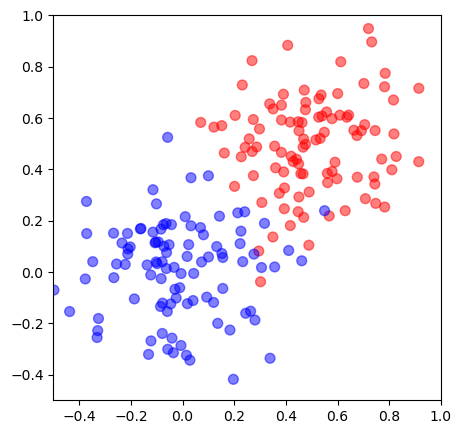

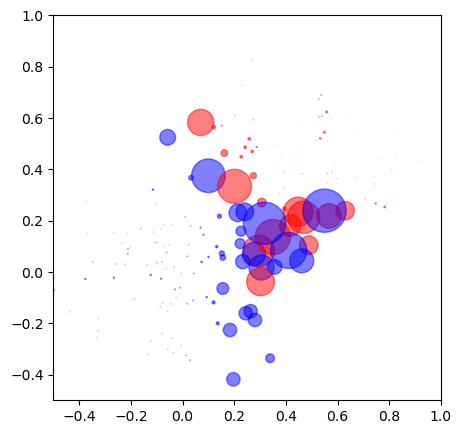

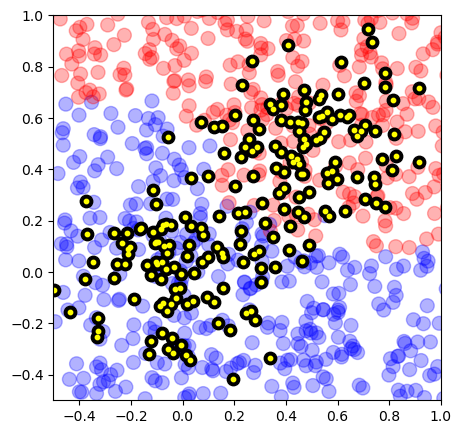

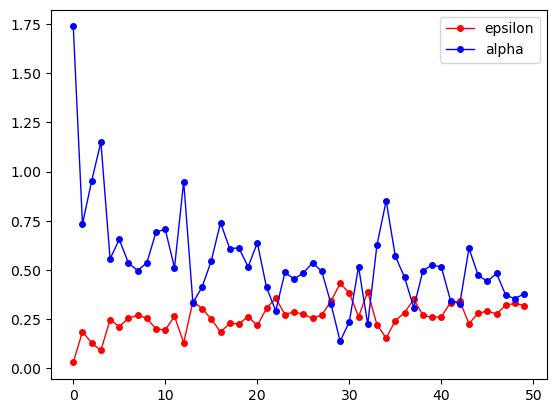

In [ ]:

import numpy as np
import random as rd
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create training data
x, y = make_blobs(n_samples=200, n_features=2,
                centers=[[0., 0.], [0.5, 0.5]],
                cluster_std=0.2, center_box=(-1., 1.))
y = y * 2 - 1    # [0, 1] --> [-1, 1]

m = x.shape[0]
R = np.arange(m)
T = 50

# [1] Figure 1: The boosting algorithm AdaBoost
# ---------------------------------------------
# Given: (x1, y1), ..., (xm, ym) where xi ∈ X, yi ∈ Y = {-1, +1}
# Initialize D1(i) = 1/m
weights = [np.array(np.ones(shape=(m,)) / m)]
eps = []      # epsilon history
alphas = []   # alpha history
models = []   # base learner models
for t in range(T):
    # sampling according to the weights
    s_idx = np.array(rd.choices(R, weights=weights[-1], k=m))
    sx = x[s_idx]      # sample x
    sy = y[s_idx]      # sample y

    # Train weak learner using distribution Dt. (Dt: weights)
    model = DecisionTreeClassifier(max_depth=2)
    model.fit(sx, sy)  # fit the model to sample data

    # Get weak hypothesis ht : X -> {-1, +1} with error
    y_pred = model.predict(x)  # predict entire training data
    i_not = np.array(y_pred != y).astype(int)  # I(y_pred ≠ y)
    eps.append(np.sum(weights[-1] * i_not))

    # Choose αt=(1/2)ln((1-εt)/εt).  (α: alpha, ε: eps)
    # For αt to be positive, εt must be less than 0.5.
    # If εt is greater than 0.5, it means it is worse than a
    # random prediction. If so, initialize the weights to 1/m again.
    if eps[-1] > 0.5:
        weights.append(np.array(np.ones(shape=(m,)) / m))
        alphas.append(0.0)
        print('weight re-initialized at t =', t)
    else:
        alpha = 0.5 * np.log((1 - eps[-1]) / (eps[-1] + 1e-8))
        alphas.append(alpha)

        # Update Dt.
        new_weights = weights[-1] * np.exp(-alpha * y * y_pred)
        weights.append( new_weights / new_weights.sum())  # normalize

    models.append(model)

# Output the final hypothesis:
x_test = np.random.uniform(-0.5, 1.5, (1000, 2))
H = np.zeros(shape=x_test.shape[0])
for t in range(T):
    h = models[t].predict(x_test)
    H += alphas[t] * h

y_pred = np.sign(H)

# visualize training data and the sampling weights
def plot_train(x, y, w):
    plt.figure(figsize=(5,5))
    color = ['red' if a == 1 else 'blue' for a in y]
    plt.scatter(x[:, 0], x[:, 1], s=w*10000, c=color, alpha=0.5)
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.5, 1.0)
    plt.show()

# visualize decision boundary
def plot_boundary(x, y, x_test, y_pred):
    plt.figure(figsize=(5,5))
    color = ['red' if a == 1 else 'blue' for a in y_pred]
    plt.scatter(x_test[:, 0], x_test[:, 1], s=100, c=color, alpha=0.3)
    plt.scatter(x[:, 0], x[:, 1], s=80, c='black')
    plt.scatter(x[:, 0], x[:, 1], s=10, c='yellow')
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.5, 1.0)
    plt.show()

plot_train(x, y, w=np.array(np.ones(shape=(m,)) / m))
plot_train(x, y, w=weights[-1])
plot_boundary(x, y, x_test, y_pred)

# Check the changes in α (alpha), ε (eps).
# Check that ε are all less than 0.5 and that α and ε are inversely proportional.
plt.plot(eps, marker='o', markersize=4, c='red', lw=1, label='epsilon')
plt.plot(alphas, marker='o', markersize=4, c='blue', lw=1, label='alpha')
plt.legend()
plt.show()



## AdaBoost(multiclassification)

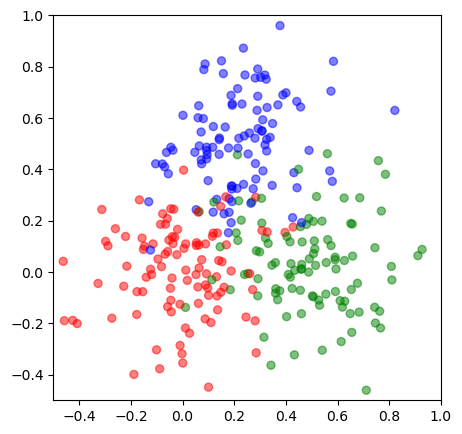

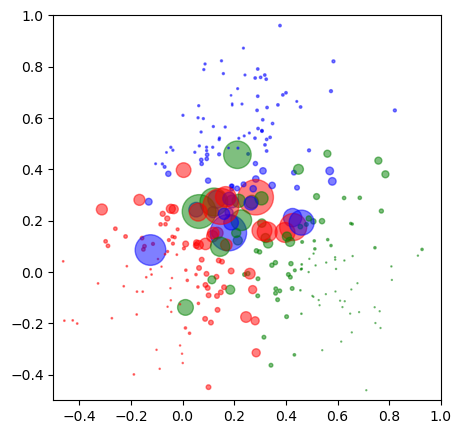

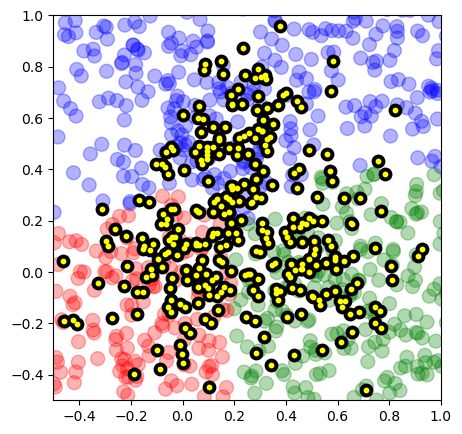

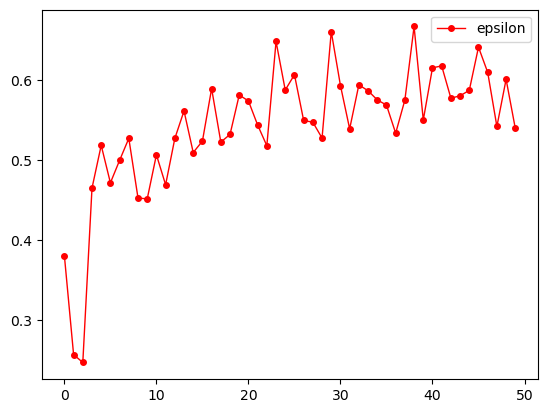

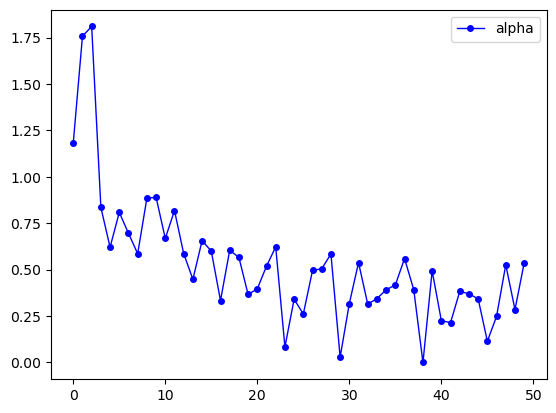

In [ ]:

import numpy as np
import random as rd
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create training data. y = {0, 1, 2}
x, y = make_blobs(n_samples=300, n_features=2,
                centers=[[0., 0.], [0.25, 0.5], [0.5, 0.]],
                cluster_std=0.18, center_box=(-1., 1.))

K = np.unique(y).shape[0]  # the number of target class = 3
m = x.shape[0]
R = np.arange(m)
T = 50

# [2] Algorithm 2: SAMME
# SAMME : Stagewise Additive Modeling using a Multi-class Exponential loss function
weights = [np.array(np.ones(shape=(m,)) / m)]
eps = []      # epsilon history
alphas = []   # alpha history
models = []   # base learner models
for t in range(T):
    # sampling according to the weights
    s_idx = np.array(rd.choices(R, weights=weights[-1], k=m))
    sx = x[s_idx]      # sample x
    sy = y[s_idx]      # sample y

    # Make sure to select at least one class of y.
    # Among y=0, 1, and 2, if only the data points with y=1 and 2
    # are selected, select one more data point with y=0.
    uy = np.unique(sy)
    if uy.shape[0] < K:
        unseen = list(set(np.unique(y)) - set(uy))
        for u in unseen:
            ui = rd.choices(np.where(y_train == u)[0], k=1)
            sx = np.vstack([sx, x_train[ui]])
            sy = np.hstack([sy, y_train[ui]])

    # base weak learner
    model = DecisionTreeClassifier(max_depth=1)
    model.fit(sx, sy)  # fit the model to sample data

    # calculate error (epsilon)
    y_pred = model.predict(x)   # predict entire training data
    i_not = np.array(y_pred != y).astype(int)  # I(y_pred ≠ y)
    eps.append(np.sum(weights[-1] * i_not))

    # calculate alpha using the error
    # For alpha to be positive, eps must be less than 1 - 1/K.
    # If eps is greater than 1 - 1/K, it means it is worse than a
    # random prediction. If so, initialize the weights to 1/m again.
    if eps[-1] > 1 - 1/K:
        weights.append(np.array(np.ones(shape=(m,)) / m))
        alphas.append(0.0)
        print('weight re-initialized at t =', t)
    else:
        alpha = np.log((1 - eps[-1]) / (eps[-1] + 1e-8)) + np.log(K - 1)
        alphas.append(alpha)

        new_weights = weights[-1] * np.exp(alpha * i_not)
        weights.append(new_weights / new_weights.sum())  # normalize

    models.append(model)

# prediction
x_test = np.random.uniform(-0.5, 1.5, (1000, 2))
H = np.zeros(shape=(x_test.shape[0], K))
for t in range(T):
    h = models[t].predict(x_test)
    oh = np.eye(K)[h]
    H += alphas[t] * oh

y_pred = np.argmax(H, axis=1)

# visualize training data and the sampling weights
def plot_train(x, y, w):
    plt.figure(figsize=(5,5))
    color = [['red', 'blue', 'green'][a] for a in y]
    plt.scatter(x[:, 0], x[:, 1], s=w*10000, c=color, alpha=0.5)
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.5, 1.0)
    plt.show()

# visualize decision boundary
def plot_boundary(x, y, x_test, y_pred):
    plt.figure(figsize=(5,5))
    color = [['red', 'blue', 'green'][a] for a in y_pred]
    plt.scatter(x_test[:, 0], x_test[:, 1], s=100, c=color, alpha=0.3)
    plt.scatter(x[:, 0], x[:, 1], s=80, c='black')
    plt.scatter(x[:, 0], x[:, 1], s=10, c='yellow')
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.5, 1.0)
    plt.show()

plot_train(x, y, w=np.array(np.ones(shape=(m,)) / m))
plot_train(x, y, w=weights[-1])
plot_boundary(x, y, x_test, y_pred)

# Check the changes in α (alpha), ε (eps).
# Check that ε are all less than 1 - 1/K
# and that α and ε are inversely proportional.
plt.plot(eps, marker='o', markersize=4, c='red', lw=1, label='epsilon')
plt.legend()
plt.show()

plt.plot(alphas, marker='o', markersize=4, c='blue', lw=1, label='alpha')
plt.legend()
plt.show()



## AdaBoost(regression)

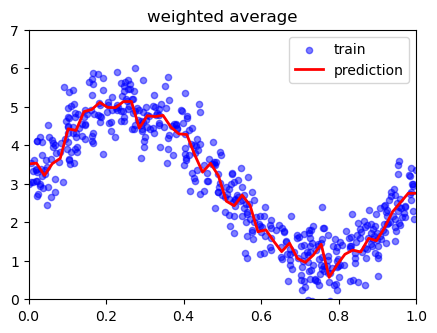

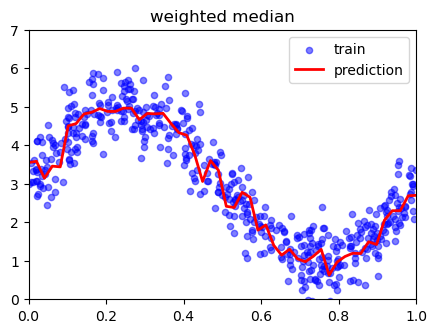

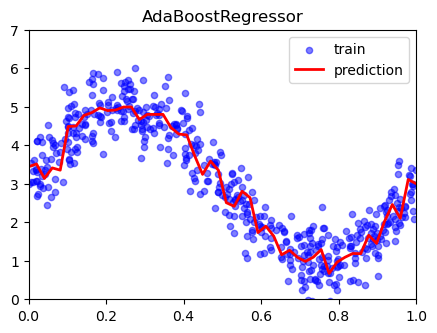

In [ ]:

import numpy as np
import random as rd
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create training data
def noisy_sine_data(n, s):
   rtn_x, rtn_y = [], []
   for i in range(n):
       x = np.random.random()
       y = 2.0 * np.sin(2.0 * np.pi * x) + np.random.normal(0.0, s) + 3.0
       rtn_x.append(x)
       rtn_y.append(y)
   return np.array(rtn_x).reshape(-1,1), np.array(rtn_y)
x, y = noisy_sine_data(n=500, s=0.5)

N = x.shape[0]
R = np.arange(N)
T = 100

weights = np.array(np.ones(shape=(N,)) / N)
beta = []     # beta history
models = []   # save base learners for prediction
for t in range(T):
    s_idx = np.array(rd.choices(R, weights=weights, k=N))
    sx = x[s_idx]      # sample x
    sy = y[s_idx]      # sample y

    # base learner
    model = DecisionTreeRegressor(max_depth=5)
    model.fit(sx, sy)  # Fit the model to sample data

    # Calculate square loss
    y_pred = model.predict(x)       # predict entire training data
    err = np.abs(y - y_pred)
    loss = (err / err.max()) ** 2      # squared loss

    loss_avg = np.sum(weights * loss)  # average loss
    if loss_avg > 0.5:
        print('stopped at t={}, loss_avg={:.2f}'.format(t, loss_avg))
        break

    # Calculate beta using average loss.
    beta.append(loss_avg / (1. - loss_avg))

    # Update weights using beta.
    new_weights = weights * np.power(beta[-1], (1. - loss))
    weights = new_weights / new_weights.sum()

    # save model
    models.append(model)

# Visualize training data and estimated curve
def plot_prediction(x, y, x_test, y_pred, title=""):
    plt.figure(figsize=(5, 3.5))
    plt.scatter(x, y, c='blue', s=20, alpha=0.5, label='train')
    plt.plot(x_test, y_pred, c='red', lw=2.0, label='prediction')
    plt.xlim(0, 1)
    plt.ylim(0, 7)
    plt.legend()
    plt.title(title)
    plt.show()

# prediction.
n_test = 50
x_test = np.linspace(0, 1, n_test).reshape(-1, 1) # test data
log_beta = np.log(1. / np.array(beta))            # log(1/beta)
y_pred = np.array([m.predict(x_test) for m in models]).T

# Method-1: Using weighted average
w = log_beta/ log_beta.sum()    # normalize
wavg_pred = np.sum(y_pred * w, axis=1)
plot_prediction(x, y, x_test, wavg_pred, 'weighted average')

# weighted median: (sum of the lower w ≥ half of the total sum of w)
i_pred = np.argsort(y_pred, axis=1)
w_acc = np.cumsum(w[i_pred], axis=1)      # accumulated w
is_med = w_acc >= 0.5 * w_acc[:, -1][:, np.newaxis]
i_med = is_med.argmax(axis=1)             # 23
y_med = i_pred[np.arange(n_test), i_med]  # 34
wmed_pred = np.array(y_pred[np.arange(n_test), y_med])  # final estimate
plot_prediction(x, y, x_test, wmed_pred, 'weighted median')

# Let’s compare the results with sklearn’s AdaBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

dt = DecisionTreeRegressor(max_depth=5)
model = AdaBoostRegressor(estimator=dt, n_estimators=T, loss='square')
model.fit(x, y)
sk_pred = model.predict(x_test)
plot_prediction(x, y, x_test, sk_pred, 'AdaBoostRegressor')

## AdaBoost(sklearn)

In [ ]:

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Read iris dataset
x, y = load_iris(return_X_y=True)

# Create training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y)

# Use the decision tree as the base weak learner.
dt = DecisionTreeClassifier(max_depth = 1)

# Generate a AdaBoost model with the SAMME algorithm.
model = AdaBoostClassifier(estimator = dt,
                           n_estimators = 100,
                           algorithm = 'SAMME')  # default = 'SAMME.R'

# Fit the model to the training data
model.fit(x_train, y_train)

# Predict the class of test data and calculate the accuracy
y_pred = model.predict(x_test)
accuracy = (y_pred == y_test).mean()

print('Accuracy = {:.4f}'.format(accuracy))



Accuracy = 0.9737


# GBM

## GBM(regression)

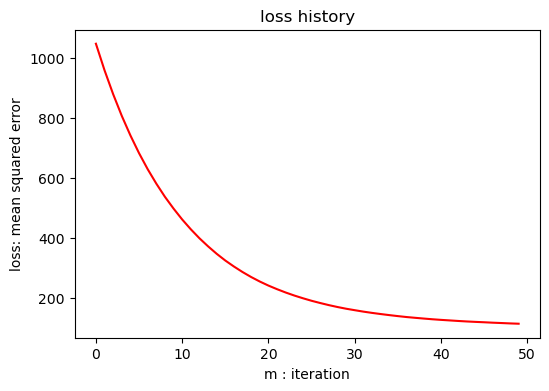

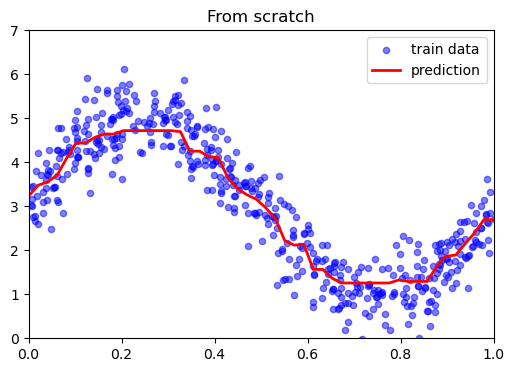

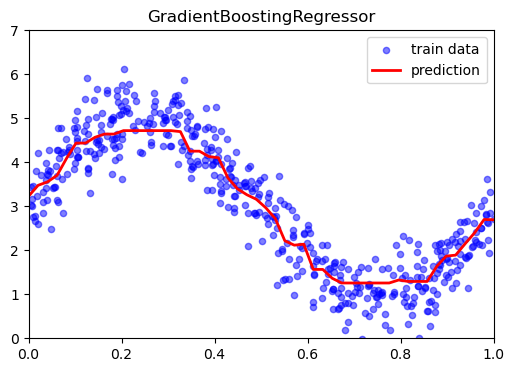

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x700388301440)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x700388301440)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x700388301440)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x700388301440)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x700388301440)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x700388301440)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
       

In [ ]:

import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create training data for regression
def nonlinear_data(n, s):
   rtn_x, rtn_y = [], []
   for i in range(n):
       x = np.random.random()
       y = 2.0 * np.sin(2.0 * np.pi * x) + np.random.normal(0.0, s) + 3.0
       rtn_x.append(x)
       rtn_y.append(y)

   return np.array(rtn_x).reshape(-1,1), np.array(rtn_y)

# Create training data
x, y = nonlinear_data(n=500, s=0.5)

n_depth = 3      # tree depth
n_tree = 50      # the number of trees (M)
alpha = 0.05     # learning rate

# step-1: Initialize model with a constant value.
F0 = y.mean()

# Training
Fm = F0
models = []
loss = []
for m in range(n_tree):
    # step-2 (A): Compute so-called pseudo-residuals
    residual = y - Fm

    # step-2 (B): Fit a regression tree to the residual
    gb_model = DecisionTreeRegressor(max_depth=n_depth)
    gb_model.fit(x, residual)

    # step-2 (C): compute gamma (prediction)
    gamma = gb_model.predict(x)

    # step-2 (D): Update the model
    Fm = Fm + alpha * gamma

    # Store trained tree models
    models.append(gb_model)

    # Calculate loss. loss = mean squared error.
    loss.append(((y - Fm) ** 2).sum())

# step-3: Output Fm(x) – Prediction of test data
y_pred = F0
x_test = np.linspace(0, 1, 50).reshape(-1, 1)
for model in models:
    y_pred += alpha * model.predict(x_test)

# Check the loss history
plt.figure(figsize=(6,4))
plt.plot(loss, c='red')
plt.xlabel('m : iteration')
plt.ylabel('loss: mean squared error')
plt.title('loss history')
plt.show()

# Visualize the training data and prediction results
def plot_prediction(x, y, x_test, y_pred, title):
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, c='blue', s=20, alpha=0.5, label='train data')
    plt.plot(x_test, y_pred, c='red', lw=2.0, label='prediction')
    plt.xlim(0, 1)
    plt.ylim(0, 7)
    plt.legend()
    plt.title(title)
    plt.show()

plot_prediction(x, y, x_test, y_pred, 'From scratch')

# Compare with the results of sklearn’s GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

sk_model = GradientBoostingRegressor(n_estimators=n_tree,
                                     learning_rate=alpha,
                                     max_depth=n_depth)

sk_model.fit(x, y)                 # training
y_pred = sk_model.predict(x_test)  # prediction

# Visualize the training data and prediction results
plot_prediction(x, y, x_test, y_pred, 'GradientBoostingRegressor')

sk_model.estimators_

## SGBM(regression)

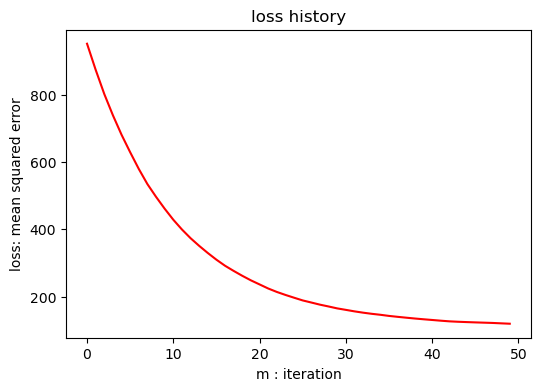

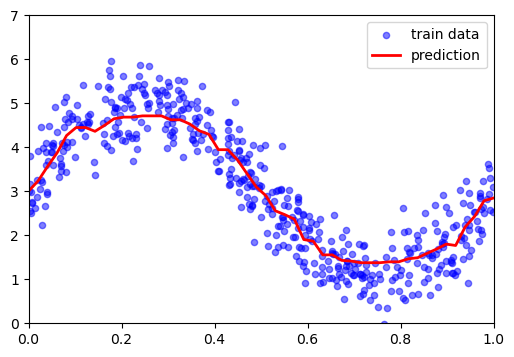

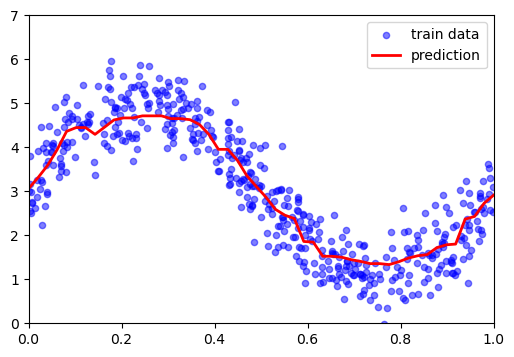

In [ ]:

import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create training data for regression
def nonlinear_data(n, s):
   rtn_x, rtn_y = [], []
   for i in range(n):
       x = np.random.random()
       y = 2.0 * np.sin(2.0 * np.pi * x) + np.random.normal(0.0, s) + 3.0
       rtn_x.append(x)
       rtn_y.append(y)

   return np.array(rtn_x).reshape(-1,1), np.array(rtn_y)

# Visualize the training data and prediction results
def plot_prediction(x, y, x_test, y_pred):
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, c='blue', s=20, alpha=0.5, label='train data')
    plt.plot(x_test, y_pred, c='red', lw=2.0, label='prediction')
    plt.xlim(0, 1)
    plt.ylim(0, 7)
    plt.legend()
    plt.show()

# Create training data
x, y = nonlinear_data(n=500, s=0.5)

n_data = x.shape[0]
n_depth = 3         # tree depth (weak learner)
n_tree = 50         # the number of trees (M)
f_rate = 0.5        # rate of sampling
lr = 0.05           # learning rate

# step-1: Initialize model with a constant value.
F0 = y.mean()

# Training
Fm = np.repeat(F0, n_data)
models = []
loss = []
for m in range(n_tree):
    # data sampling without replacement
    si = np.random.choice(range(n_data), int(n_data * f_rate), replace=False)

    # step-2 (A): Compute so-called pseudo-residuals
    residual = y[si] - Fm[si]

    # step-2 (B): Fit a regression tree to the residual
    gb_model = DecisionTreeRegressor(max_depth=n_depth)
    gb_model.fit(x[si], residual)

    # step-2 (C): compute gamma (prediction)
    gamma = gb_model.predict(x)

    # step-2 (D): Update the model
    Fm = Fm + lr * gamma

    # Store trained tree models
    models.append(gb_model)

    # Calculate loss. loss = mean squared error.
    loss.append(((y - Fm) ** 2).sum())

# Check the loss history
plt.figure(figsize=(6,4))
plt.plot(loss, c='red')
plt.xlabel('m : iteration')
plt.ylabel('loss: mean squared error')
plt.title('loss history')
plt.show()

# step-3: Output Fm(x) - Prediction
y_pred = F0
x_test = np.linspace(0, 1, 50).reshape(-1, 1)
for model in models:
    y_pred += lr * model.predict(x_test)

# Visualize the training data and prediction results
plot_prediction(x, y, x_test, y_pred)

# Compare with the results of sklearn’s GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
sk_model = GradientBoostingRegressor(n_estimators=n_tree,
                                     learning_rate=lr,
                                     max_depth=n_depth,
                                     subsample=f_rate)

sk_model.fit(x, y)                 # Training
y_pred = sk_model.predict(x_test)  # Prediction

plot_prediction(x, y, x_test, y_pred)

## GBM (Classification)

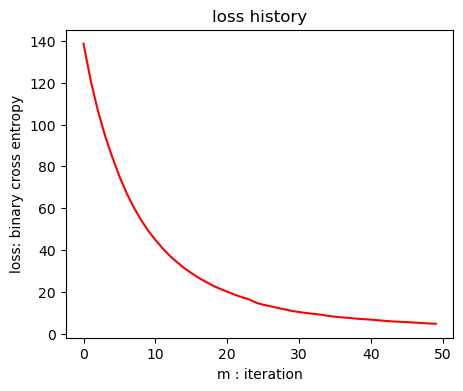

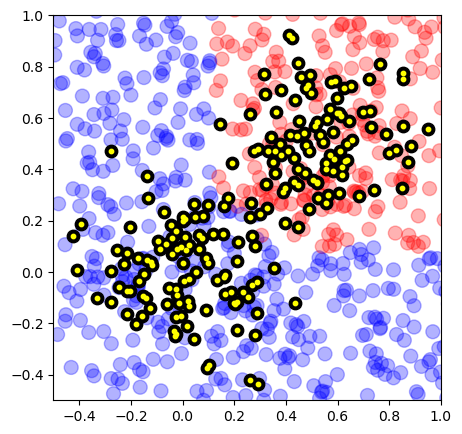

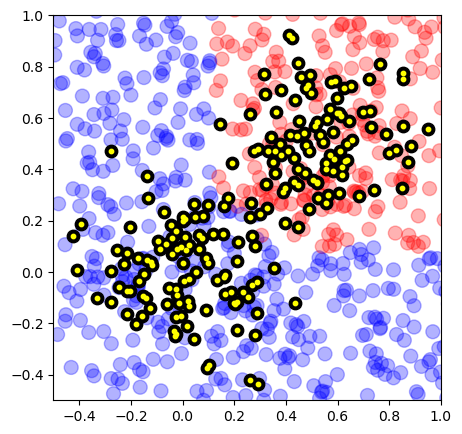

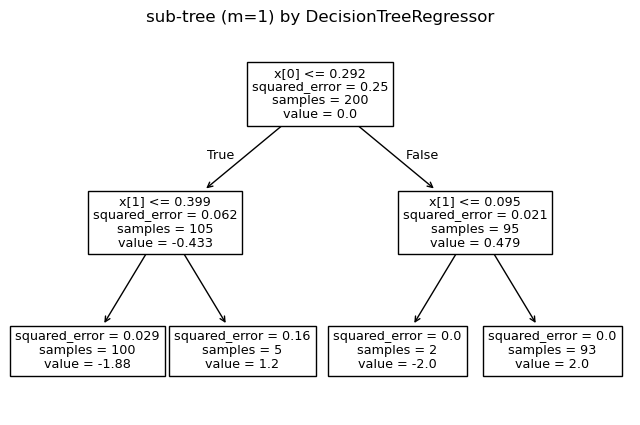

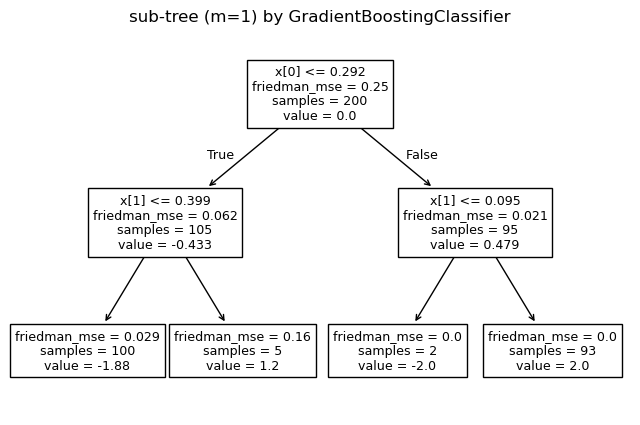

In [ ]:

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# log(odds) --> probability
def F2P(f):
    return 1. / (1. + np.exp(-f))

# Creating training data
x, y = make_blobs(n_samples=200, n_features=2,
                  centers=[[0., 0.], [0.5, 0.5]],
                  cluster_std=0.18, center_box=(-1., 1.))

n_data = x.shape[0]
n_depth = 2    # tree depth
n_tree = 50    # the number of trees (M)
alpha = 0.1    # learning rate

# step-1: Initialize model with a constant value.
F0 = np.log(y.mean() / (1. - y.mean()))
Fm = np.repeat(F0, n_data)

models = []
loss = []
for m in range(n_tree):
    # step-2 (A): Compute so-called pseudo-residuals
    y_hat = F2P(Fm)
    residual = y - y_hat

    # step-2 (B): Fit a regression tree to the residual
    gb_model = DecisionTreeRegressor(max_depth=n_depth)
    gb_model.fit(x, residual)

    # The leaf nodes of this tree contain the average of the
    # residuals. The predict() function returns this average value.
    # We replace these values ​​with the leaf values gamma. Then the
    # predict() function will return the gamma.

    # step-2 (C): compute gamma
    # leaf_id = The leaf node number to which x belongs.
    leaf_id = gb_model.tree_.apply(x.astype(np.float32))

    # Replace the leaf values ​​of all leaf nodes with their gamma
    # values, ​​and update Fm.
    for j in np.unique(leaf_id):
        # i=Index of data points belonging to leaf node j.
        i = np.where(leaf_id == j)[0]
        gamma = residual[i].sum() / (y_hat[i] * (1. - y_hat[i])).sum()

        # step-2 (D): Update the model
        Fm[i] += alpha * gamma

        # Replace the leaf values ​​with their gamma
        # gb_model.tree_.value.shape = (7, 1, 1)
        gb_model.tree_.value[j, 0, 0] = gamma

    # save the trained model
    models.append(gb_model)

    # Calculating loss. loss = binary cross entropy.
    loss.append(-(y * np.log(y_hat + 1e-8) + \
                 (1.- y) * np.log(1.- y_hat + 1e-8)).sum())

# Check the loss history visually.
plt.figure(figsize=(5,4))
plt.plot(loss, c='red')
plt.xlabel('m : iteration')
plt.ylabel('loss: binary cross entropy')
plt.title('loss history')
plt.show()

# step-3: Output Fm(x) - Prediction of test data
Fm = F0
x_test = np.random.uniform(-0.5, 1.5, (1000, 2))

for model in models:
    Fm += alpha * model.predict(x_test)

y_prob = F2P(Fm)
y_pred = (y_prob > 0.5).astype('uint8')

# Visualize training and prediction results.
def plot_prediction(x, y, x_test, y_pred):
    plt.figure(figsize=(5,5))
    color = ['red' if a == 1 else 'blue' for a in y_pred]
    plt.scatter(x_test[:, 0], x_test[:, 1], s=100, c=color,
                alpha=0.3)
    plt.scatter(x[:, 0], x[:, 1], s=80, c='black')
    plt.scatter(x[:, 0], x[:, 1], s=10, c='yellow')
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.5, 1.0)
    plt.show()

# Visualize test data and y_pred.
plot_prediction(x, y, x_test, y_pred)

# Compare with Sklearn's GradientBoostingClassifier result.
from sklearn.ensemble import GradientBoostingClassifier

sk_model = GradientBoostingClassifier(n_estimators=n_tree,
                                      learning_rate=alpha,
                                      max_depth=n_depth)
sk_model.fit(x, y)

# Predict the target class of test data.
y_pred1 = sk_model.predict(x_test)

# Visualize test data and y_pred1.
plot_prediction(x, y, x_test, y_pred1)

# Check the first tree with the naked eye.
# Check that the trees generated by the two methods match well.
plt.figure(figsize=(8,5))
plot_tree(models[0])
plt.title('sub-tree (m=1) by DecisionTreeRegressor')
plt.show()

plt.figure(figsize=(8,5))
plot_tree(sk_model.estimators_[0 ,0])
plt.title('sub-tree (m=1) by GradientBoostingClassifier')
plt.show()

## SGBM(Classification)

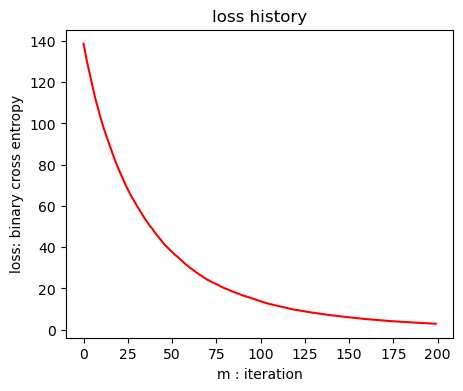

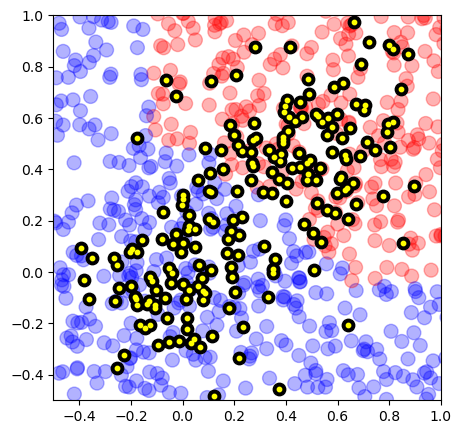

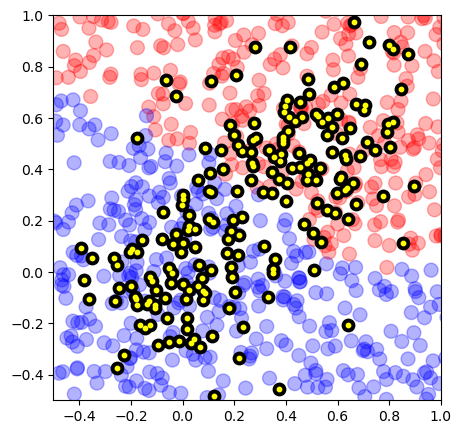

In [ ]:

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# log(odds) --> probability
def F2P(f):
    return 1. / (1. + np.exp(-f))

# Creating training data
x, y = make_blobs(n_samples=200, n_features=2,
                  centers=[[0., 0.], [0.5, 0.5]],
                  cluster_std=0.2, center_box=(-1., 1.))

n_data = x.shape[0]
n_depth = 2    # tree depth
n_tree = 200   # the number of trees (M)
f_rate = 0.5   # sampling ratio
alpha = 0.05   # learning rate

# step-1: Initialize model with a constant value.
F0 = np.log(y.mean() / (1. - y.mean()))
Fm = np.repeat(F0, n_data)

# Repeat
models = []
loss = []
for m in range(n_tree):
    # data sampling without replacement
    si = np.random.choice(range(n_data), int(n_data * f_rate), replace=False)

    # step-2 (A): Compute so-called pseudo-residuals
    y_hat = F2P(Fm)
    residual = y[si] - y_hat[si]

    # step-2 (B): Fit a regression tree to the residual
    gb_model = DecisionTreeRegressor(max_depth=n_depth)
    gb_model.fit(x[si], residual)

    # The leaf nodes of this tree contain the average of the
    # residuals. The predict() function returns this average value.
    # We replace these values ​​with the leaf values gamma. Then the
    # predict() function will return the gamma.

    # step-2 (C): compute gamma
    # leaf_id = The leaf node number to which x[si] belongs.
    leaf_id = gb_model.tree_.apply(x[si].astype(np.float32))

    # Replace the leaf values ​​of all leaf nodes with their gamma
    # values, ​​and update Fm.
    for j in np.unique(leaf_id):
        # i=Index of data points belonging to leaf node j.
        i = np.where(leaf_id == j)[0]
        xi = si[i]
        gamma = residual[i].sum() / (y_hat[xi] * (1. - y_hat[xi])).sum()

        # step-2 (D): Update the model
        Fm[xi] += alpha * gamma

        # Replace the leaf values ​​with their gamma
        # gb_model.tree_.value.shape = (7, 1, 1)
        gb_model.tree_.value[j, 0, 0] = gamma

    # save the trained model
    models.append(gb_model)

    # Calculating loss. loss = binary cross entropy.
    loss.append(-(y * np.log(y_hat + 1e-8) + \
                 (1.- y) * np.log(1.- y_hat + 1e-8)).sum())

# Check the loss history visually.
plt.figure(figsize=(5,4))
plt.plot(loss, c='red')
plt.xlabel('m : iteration')
plt.ylabel('loss: binary cross entropy')
plt.title('loss history')
plt.show()

# step-3: Output Fm(x) - Prediction of test data
Fm = F0
x_test = np.random.uniform(-0.5, 1.5, (1000, 2))

for model in models:
    Fm += alpha * model.predict(x_test)

y_prob = F2P(Fm)
y_pred = (y_prob > 0.5).astype('uint8')

# Visualize training and prediction results.
def plot_prediction(x, y, x_test, y_pred):
    plt.figure(figsize=(5,5))
    color = ['red' if a == 1 else 'blue' for a in y_pred]
    plt.scatter(x_test[:, 0], x_test[:, 1], s=100, c=color,
                alpha=0.3)
    plt.scatter(x[:, 0], x[:, 1], s=80, c='black')
    plt.scatter(x[:, 0], x[:, 1], s=10, c='yellow')
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.5, 1.0)
    plt.show()

# Visualize test data and y_pred.
plot_prediction(x, y, x_test, y_pred)

# Compare with Sklearn's GradientBoostingClassifier result.
from sklearn.ensemble import GradientBoostingClassifier
sk_model = GradientBoostingClassifier(n_estimators=n_tree,
                                      learning_rate=alpha,
                                      max_depth=n_depth,
                                      subsample=f_rate)
sk_model.fit(x, y)

# Predict the target class of test data.
y_pred1 = sk_model.predict(x_test)

# Visualize test data and y_pred1.
plot_prediction(x, y, x_test, y_pred1)


## GBM(Multi-classification)

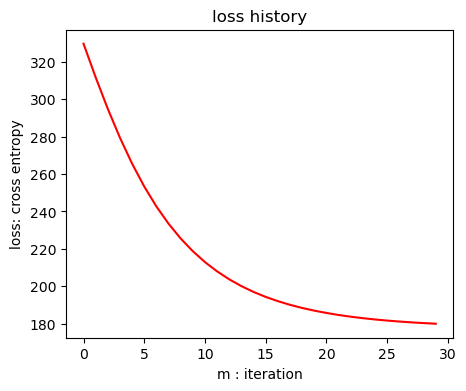

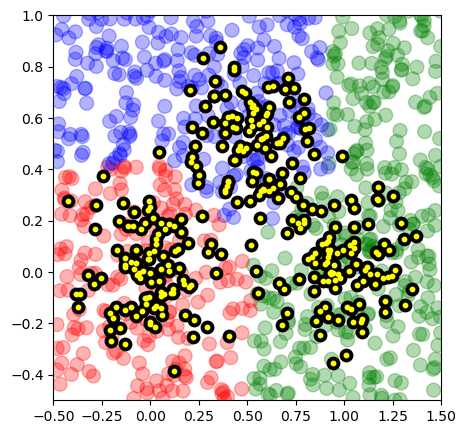

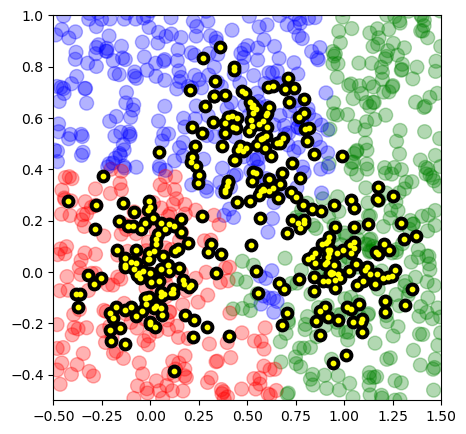

array([DecisionTreeRegressor(max_depth=2,
                             random_state=RandomState(MT19937) at 0x700388301440),
       DecisionTreeRegressor(max_depth=2,
                             random_state=RandomState(MT19937) at 0x700388301440),
       DecisionTreeRegressor(max_depth=2,
                             random_state=RandomState(MT19937) at 0x700388301440)],
      dtype=object)

In [ ]:

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

# Create training data
x, y = make_blobs(n_samples=300, n_features=2,
                  centers=[[0., 0.], [0.5, 0.5], [1.0, 0.]],
                  cluster_std=0.18, center_box=(-1., 1.))

# One-hot encoding of y
y_ohe = OneHotEncoder().fit_transform(y.reshape(-1,1)).toarray()

# log(odds) --> probability
def F2P(f):
    return 1. / (1. + np.exp(-f))

def softmax(x):
    x = x - x.max(axis=1, keepdims=True)
    ex = np.exp(x)
    return ex / ex.sum(axis=1, keepdims=True)

n_data = x.shape[0]
n_class = y_ohe.shape[1]
n_depth = 2    # tree depth
n_tree = 30    # the number of trees (M)
alpha = 0.1    # learning rate
u_class = np.unique(y)

# GradientBoostingClassifier: multi-class
# https://scikit-learn.org/stable/modules/ensemble.html
# Note: Classification with more than 2 classes requires the induction
# of n_classes regression trees at each iteration, thus, the total number
# of induced trees equals n_classes * n_estimators.

# step-1: Initialize model with a constant value.
# F0, Fm.shape = (n_data, n_class)
F0 = [np.log(y_ohe[:,c].mean()/(1. - y_ohe[:,c].mean())) for c in u_class]
Fm = np.tile(np.array(F0), [n_data, 1])

# Repeat
gb_models = []
loss = []
for m in range(n_tree):
    # step-2 (A): Compute so-called pseudo-residuals
    # y_hat, residual.shape = (n_data, n_class)
    prob = F2P(Fm)
    y_hat = softmax(prob)
    residual = y_ohe - y_hat

    # step-2 (B): Fit a regression tree to the residual
    gb_model = []
    for ci in u_class:
        gb_model.append(DecisionTreeRegressor(max_depth=n_depth))
        gb_model[-1].fit(x, residual[:, ci])

        # step-2 (C): compute gamma
        # leaf_id = The leaf node number to which x belongs.
        leaf_id = gb_model[-1].tree_.apply(x.astype(np.float32))

        # Replace the leaf values ​​of all leaf nodes with their gamma
        # values, ​​and update Fm.
        for j in np.unique(leaf_id):
            # xi=index of data points belonging to leaf node j.
            xi = np.where(leaf_id == j)[0]
            gamma = residual[:, ci][xi].sum() / \
                    (y_hat[:, ci][xi] * (1. - y_hat[:, ci][xi])).sum()

            # step-2 (D): Update the model
            Fm[:, ci][xi] += alpha * gamma

            # Replace the leaf values ​​with their gamma
            gb_model[-1].tree_.value[j, 0, 0] = gamma

    gb_models.append(gb_model)

    # Calculating loss. loss = cross entropy.
    loss.append(-np.sum((y_ohe * np.log(y_hat + 1e-8)).sum(axis=1)))

# Check the loss history visually.
plt.figure(figsize=(5,4))
plt.plot(loss, c='red')
plt.xlabel('m : iteration')
plt.ylabel('loss: cross entropy')
plt.title('loss history')
plt.show()

# step-3: Output Fm(x) - Prediction of test data
x_test = np.random.uniform(-0.5, 1.5, (1000, 2))

Fm = np.tile(np.array(F0), [x_test.shape[0], 1])
for model in gb_models:
    for ci in u_class:
        Fm[:, ci] += alpha * model[ci].predict(x_test)

y_prob = F2P(Fm)
y_soft = softmax(y_prob)
y_pred = np.argmax(y_soft, axis=1)

# Visualize training and prediction results.
def plot_prediction(x, y, x_test, y_pred):
    plt.figure(figsize=(5,5))
    color = [['red', 'blue', 'green'][a] for a in y_pred]
    plt.scatter(x_test[:, 0], x_test[:, 1], s=100, c=color,
                alpha=0.3)
    plt.scatter(x[:, 0], x[:, 1], s=80, c='black')
    plt.scatter(x[:, 0], x[:, 1], s=10, c='yellow')
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.0)
    plt.show()

# Visualize test data and y_pred.
plot_prediction(x, y, x_test, y_pred)

# Compare with Sklearn's GradientBoostingClassifier result.
from sklearn.ensemble import GradientBoostingClassifier

sk_model = GradientBoostingClassifier(n_estimators=n_tree,
                                      learning_rate=alpha,
                                      max_depth=n_depth,
                                      criterion='squared_error')
sk_model.fit(x, y)

# Predict the target class of test data.
y_pred1 = sk_model.predict(x_test)

# Visualize test data and y_pred1.
plot_prediction(x, y, x_test, y_pred1)

sk_model.estimators_.shape
sk_model.estimators_[0]